In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np 
import os
import tensorflow as tf
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.compat.v1.disable_eager_execution()

from keras.utils.np_utils import to_categorical
from keras import metrics
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


import cv2
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.utils import shuffle 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import math
import random


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [6]:
class_names = ["damaged_infrastructure", "damaged_nature", "fires", "flood", "human_damage", "non_damage"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
num_classes = len(class_names)

## Test to check that our classes are correct for classifcation:
print(num_classes)
print(class_names)

IMAGE_SIZE = (150,150)

6
['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage']


In [7]:
def load_data():
    
    datasets = ["/content/drive/MyDrive/Neural Project/TRAIN_DATA150x150" , "/content/drive/MyDrive/Neural Project/TEST_DATA150x150"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
## Function to plot the accuracy loss as a response to the history: 

def plot_accuracy_loss(history):
  fig = plt.figure(figsize = (30, 15) )


  plt.subplot(221)
  plt.plot(history.history["Accuracy"], "bo--", label = "Accuracy")
  plt.plot(history.history["Val_Accuracy"], "ro--", label = "Val_Accuracy")
  plt.title("Train Accuracy vs, Val Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(222)
  plt.plot(history.history["Loss"], "bo--", label = "Loss")
  plt.plot(history.history["Val_Loss"], "ro--", label = "Val_Loss")
  plt.title("Train Loss vs, Val Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

In [9]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image # : '.format(index) + class_names[labels[index]])
    plt.show()

  
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [10]:
(train_images, train_labels), (test_images, test_labels)  = load_data()
print("Done")

Loading /content/drive/MyDrive/Neural Project/TRAIN_DATA150x150


100%|██████████| 192/192 [00:47<00:00,  4.04it/s]


Loading /content/drive/MyDrive/Neural Project/TEST_DATA150x150


100%|██████████| 69/69 [00:16<00:00,  4.07it/s]


Done


In [11]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 4715
Number of testing examples: 1174
Each image is of size: (150, 150)


In [12]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

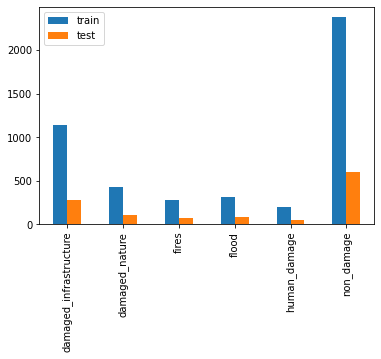

In [13]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

Sidenote: The seemingly huge unbalance between non_damage data and the rest can be explained through the comparison of

In [14]:
total_damage = 0
for i in range(len(train_counts)-1):
    total_damage += train_counts[i]

print(total_damage)

total_non_damage = train_counts[-1]
print(total_non_damage)

2337
2378


In [15]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

batch_size=128
width = 150

### train_steps_per_epoch=math.ceil(train_images.samples/batch_size)
### valid_steps_per_epoch=math.ceil(valid_data.samples/batch_size)
### test_steps_per_epoch=math.ceil(test_data.samples/batch_size)

In [16]:
print(train_labels)
print(class_names_label)

[1 0 5 ... 5 5 1]
{'damaged_infrastructure': 0, 'damaged_nature': 1, 'fires': 2, 'flood': 3, 'human_damage': 4, 'non_damage': 5}


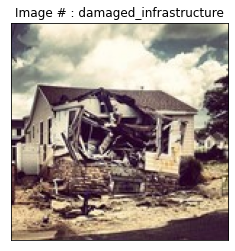

In [17]:
display_random_image(class_names, train_images, train_labels)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units = 512, activation = 'relu'),
    #tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dense(units = 6, activation = 'softmax'),
]) 

#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])

#model = VGG16(weights = 'imagenet', include_top = False)

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 256)       0

In [ ]:
#train_features = model.predict(train_images)
#test_features = model.predict(test_images)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',
                       f1_m,
                       precision_m,
                       recall_m
                      ])

In [ ]:
#encoded_labels = to_categorical(train_labels)
#print(encoded_labels)
#print(encoded_labels.shape)

In [ ]:
num_epochs = 20
history = model.fit(train_images, train_labels, batch_size=128, epochs= num_epochs, validation_split = 0.15)

Train on 3999 samples, validate on 706 samples
Epoch 1/20
3999/3999 [==============================] - 293s 73ms/sample - loss: 1.4610 - accuracy: 0.4806 - f1_m: 3.9852 - precision_m: 1618437376.0000 - recall_m: 2.4416 - val_loss: 1.3647 - val_accuracy: 0.5184 - val_f1_m: 4.7981 - val_precision_m: 2145000064.0000 - val_recall_m: 2.3991
Epoch 2/20
2176/3999 [===============>..............] - ETA: 2:02 - loss: 1.3815 - accuracy: 0.5152 - f1_m: 3.2206 - precision_m: 1261764608.0000 - recall_m: 2.0367

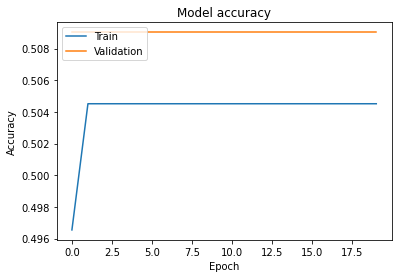

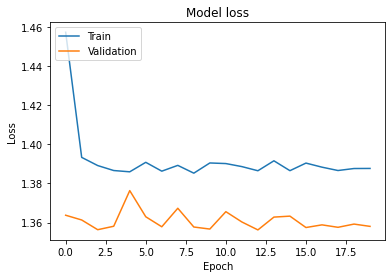

In [ ]:
## Plotting the accuracy over time. 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss over time
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

In [ ]:
#encoded_test_labels = to_categorical(test_labels)
#print(encoded_test_labels)
#print(encoded_test_labels.shape)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
(1174, 6)


In [ ]:
test_loss = model.evaluate(test_images, test_labels)

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

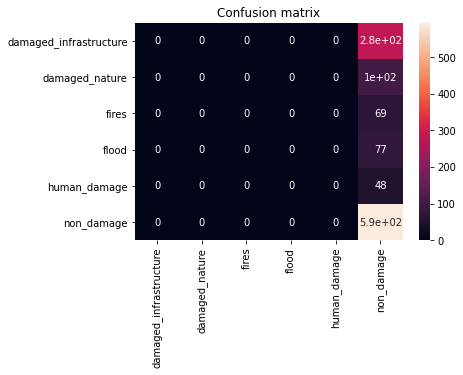

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sb.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

,AUC
0,0.766558
1,0.790605
2,0.850259
3,0.838982
4,0.751258
5,0.780551


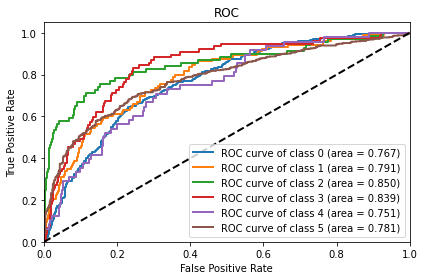

In [ ]:
y = to_categorical(test_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.shape[1]  

# compare each class's probabilities one by one
# each acts like a single column
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the AUC scores
from IPython.display import display
import pandas as pd
auc_array = np.array(list(roc_auc.items()))
df = pd.DataFrame(auc_array[:,1])
df.columns = ['AUC']
display(df)

# Draw the pairwise ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC.png')
plt.show()

In [ ]:
plt.plot(history.history['precision_m'],label='precision')
plt.plot(history.history['val_precision'],label='val_precision')
plt.plot(history.history['recall'],label='recall')
plt.plot(history.history['val_recall'],label='val_precision')
plt.title('Model Precision and Recall')
plt.ylabel('Precision and Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()

KeyError: 'precision'

In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       283
           1       0.00      0.00      0.00       103
           2       0.07      0.64      0.13        69
           3       0.08      0.56      0.14        77
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00       594

    accuracy                           0.07      1174
   macro avg       0.02      0.20      0.04      1174
weighted avg       0.01      0.07      0.02      1174



C:\Users\dodi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dodi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dodi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(8, input_dim = 784,activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
  )
  return model

In [ ]:
n_split=10
 
# We will split the the data n_split times
# and create and for the model with the said
# parameters

results = list()
for train_index,test_index in KFold(n_split).split(X_train): 
  # use the index to generate training an testing sets
  x_train,x_test=X_train[train_index],X_train[test_index]
  y_train,y_test=Y_train[train_index],Y_train[test_index]
  
  # create and fit the model
  model=create_model()
  model.fit(x_train, y_train,epochs=30)
  
  # print and show generic metrics available
  scores = model.evaluate(x_test,y_test)
 
  # print the model metrics
  for i,names in zip(np.arange(0,len(model.metrics_names)),model.metrics_names):
      print(model.metrics_names[i],'=',scores[i])
  # calculate and print more metrics
  actual, predicted = generate_actual_predicted(model, x_test, y_test)
  print("precision ",precision_score(actual, predicted, average='macro'))
  print("recall ", recall_score(actual, predicted, average='macro'))
  print("F1-Score ", f1_score(actual, predicted, average='macro'))
  results.append([precision_score(actual, predicted, average='macro'),
                  recall_score(actual, predicted, average='macro'), 
                  f1_score(actual, predicted, average='macro') ])